In [1]:
import numpy as np
from datetime import datetime 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# hyper parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 10
N_EPOCHS = 15

N_CLASSES = 2

In [3]:
train_data = pd.read_csv("ppca_reduced.csv").to_numpy()

In [4]:
train_data = train_data[:100,:]

In [5]:
y = train_data[:,1]
#y = np.concatenate((y, -y+1), axis = 1)
x = train_data[:,2:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [6]:
x 

array([[-2.15519831e-01,  6.91961880e-01, -1.43739960e-01, ...,
         6.50601540e-02, -4.65584427e-01,  6.12748151e-01],
       [-8.56583006e-02,  6.91479206e-01,  2.83176773e-02, ...,
         2.75331869e-03, -6.53028922e-01,  3.06203995e-01],
       [ 1.41101305e-01, -7.17861512e-01, -3.55457287e-02, ...,
        -7.32753675e-01, -6.77414452e-01,  8.70840697e-02],
       ...,
       [-1.58065381e-01,  4.95242396e-01, -2.09124191e-01, ...,
         9.82661383e-02, -2.02177187e-03, -3.29395517e-01],
       [ 1.08677721e+00,  5.11117191e-01,  2.87972352e+00, ...,
         7.87410492e-01,  2.15564266e+00, -4.73646410e-01],
       [ 3.64029235e-02,  3.05663455e-01, -5.08496157e-01, ...,
         1.60886276e-01,  2.72361464e-01, -1.59557489e-01]])

In [7]:
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train =torch.from_numpy(y_train.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32)) 
y_test = torch.from_numpy(y_test.astype(np.float32))
y_train = y_train.view(y_train.shape[0],1) 
y_test =y_test.view(y_test.shape[0],1)

In [8]:
train = data_utils.TensorDataset(x_train,y_train)
test = data_utils.TensorDataset(x_test,y_test)
train_loader = data_utils.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = data_utils.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

In [9]:
def train(train_loader, model, criterion, optimizer):
    '''
    Train one epoch.
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()

    
        # Forward pass
        y_hat, _ = model(X) 
        #print(y_hat)
        print(y_true)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [10]:
def validate(valid_loader, model, criterion):
    '''
    Function for the validation step of the training loop.
    Returns the model and the loss on the test set.
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:

        # Forward pass and record loss
        y_hat, _ = model(X) 
        #print(y_hat)
        #print(y_true)
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [11]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader,)
            print(train_acc)
            train_accs.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader)
            valid_accs.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
    
    performance = {
        'train_losses':train_losses,
        'valid_losses': valid_losses,
        'train_acc': train_accs,
        'valid_acc':valid_accs
    }
    
    return model, optimizer, performance

In [12]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            _, y_prob = model(X)
            #print(y_prob)
            #_, predicted_labels = torch.max(y_prob, 1)
            predicted_labels = (y_prob > 0.5)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
            #print(correct_pred)

    return correct_pred.float() / n


    
def plot_performance(performance):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    for key, value in performance.items():
        if 'loss' in key:
            ax[0].plot(value, label=key) 
        else:
            ax[1].plot(value, label=key) 
    ax[0].set(title="Loss  over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].set(title="accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[0].legend()
    ax[1].legend()
    plt.show()
    
    # change the plot style to default
    plt.style.use('default')    

In [13]:
class MLP(nn.Module):

    def __init__(self, layers):
        super(MLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=layers[0], out_features=layers[1]),
            nn.BatchNorm1d(layers[1]), 
            nn.Sigmoid(),
            nn.Linear(in_features=layers[1], out_features=layers[2]),
            nn.BatchNorm1d(layers[2]),
            nn.Tanh(),
            nn.Linear(in_features=layers[2], out_features=layers[3]),
            nn.BatchNorm1d(layers[3]), 
            nn.Sigmoid(),
            nn.Linear(in_features=layers[3], out_features=layers[4]),
            nn.BatchNorm1d(layers[4]), 
            nn.Sigmoid(),
            nn.Linear(in_features=layers[4], out_features=layers[5]),
            nn.BatchNorm1d(layers[5]),
            nn.Tanh(),
            nn.Linear(in_features=layers[5], out_features=layers[6]),
            nn.BatchNorm1d(layers[6]),
            nn.Sigmoid(),
            nn.Linear(in_features=layers[6], out_features=layers[-1]),
            nn.BatchNorm1d(layers[-1]),
            nn.Sigmoid(),
        )
       
    def forward(self, x):
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [14]:
torch.manual_seed(RANDOM_SEED)
layers = [12, 64, 128, 128, 128, 64, 16, 1]
model = MLP(layers)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Tanh()
    (15): Linear(in_features=64, out_features=16, bias=True)
    (16): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=

In [15]:
model, optimizer, performance_2 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]])
tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]])
tensor([[1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor(0.2250)
02:01:25 Epoch: 7	Train loss: 0.6013	Valid loss: 0.7673	Train accuracy: 22.50	Valid accuracy: 20.00
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
tensor([[0.],
        [1.],
        [1.

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor(0.2250)
02:01:25 Epoch: 14	Train loss: 0.5440	Valid loss: 0.7489	Train accuracy: 22.50	Valid accuracy: 20.00


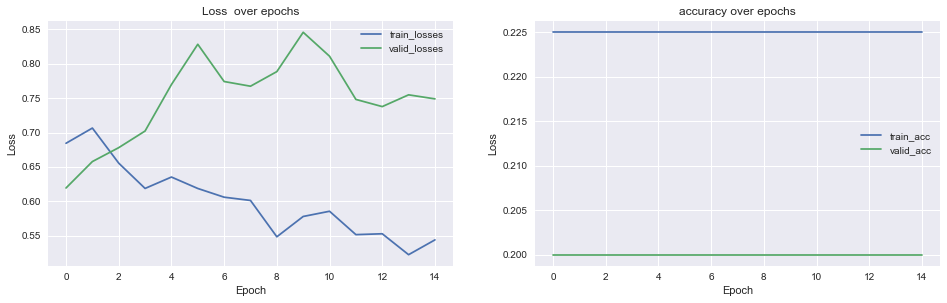

In [16]:
plot_performance(performance_2)